In [2]:
import gc
import lightgbm as lgb  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import polars as pl  # type: ignore
import warnings

from catboost import CatBoostClassifier, Pool  # type: ignore
from glob import glob
from IPython.display import display  # type: ignore
from pathlib import Path
from sklearn.base import BaseEstimator, ClassifierMixin  # type: ignore
from sklearn.metrics import roc_auc_score  # type: ignore
from sklearn.model_selection import StratifiedGroupKFold  # type: ignore
from typing import Any

warnings.filterwarnings("ignore")

ROOT = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR = ROOT / "parquet_files" / "train"
TEST_DIR = ROOT / "parquet_files" / "test"

In [3]:
class Utility:
    @staticmethod
    def get_feat_defs(ending_with: str) -> None:
        
        feat_defs: pl.DataFrame = pl.read_csv(ROOT / "feature_definitions.csv")

        filtered_feats: pl.DataFrame = feat_defs.filter(
            pl.col("Variable").apply(lambda var: var.endswith(ending_with))
        )

        with pl.Config(fmt_str_lengths=200, tbl_rows=-1):
            print(filtered_feats)

        filtered_feats = None
        feat_defs = None

    @staticmethod
    def find_index(lst: list[Any], item: Any) -> int | None:
        
        try:
            return lst.index(item)
        except ValueError:
            return None

    @staticmethod
    def dtype_to_str(dtype: pl.DataType) -> str:
        
        dtype_map = {
            pl.Decimal: "Decimal",
            pl.Float32: "Float32",
            pl.Float64: "Float64",
            pl.UInt8: "UInt8",
            pl.UInt16: "UInt16",
            pl.UInt32: "UInt32",
            pl.UInt64: "UInt64",
            pl.Int8: "Int8",
            pl.Int16: "Int16",
            pl.Int32: "Int32",
            pl.Int64: "Int64",
            pl.Date: "Date",
            pl.Datetime: "Datetime",
            pl.Duration: "Duration",
            pl.Time: "Time",
            pl.Array: "Array",
            pl.List: "List",
            pl.Struct: "Struct",
            pl.String: "String",
            pl.Categorical: "Categorical",
            pl.Enum: "Enum",
            pl.Utf8: "Utf8",
            pl.Binary: "Binary",
            pl.Boolean: "Boolean",
            pl.Null: "Null",
            pl.Object: "Object",
            pl.Unknown: "Unknown",
        }

        return dtype_map.get(dtype)

    @staticmethod
    def find_feat_occur(regex_path: str, ending_with: str) -> pl.DataFrame:
        
        feat_defs: pl.DataFrame = pl.read_csv(ROOT / "feature_definitions.csv").filter(
            pl.col("Variable").apply(lambda var: var.endswith(ending_with))
        )
        feat_defs.sort(by=["Variable"])

        feats: list[pl.String] = feat_defs["Variable"].to_list()
        feats.sort()

        occurrences: list[list] = [[set(), set()] for _ in range(feat_defs.height)]

        for path in glob(str(regex_path)):
            df_schema: dict = pl.read_parquet_schema(path)

            for feat, dtype in df_schema.items():
                index: int = Utility.find_index(feats, feat)
                if index != None:
                    occurrences[index][0].add(Utility.dtype_to_str(dtype))
                    occurrences[index][1].add(Path(path).stem)

        data_types: list[str] = [None] * feat_defs.height
        file_locs: list[str] = [None] * feat_defs.height

        for i, feat in enumerate(feats):
            data_types[i] = list(occurrences[i][0])
            file_locs[i] = list(occurrences[i][1])

        feat_defs = feat_defs.with_columns(pl.Series(data_types).alias("Data_Type(s)"))
        feat_defs = feat_defs.with_columns(pl.Series(file_locs).alias("File_Loc(s)"))

        return feat_defs

    def reduce_memory_usage(df: pl.DataFrame, name) -> pl.DataFrame:
        
        print(
            f"Memory usage of dataframe \"{name}\" is {round(df.estimated_size('mb'), 4)} MB."
        )

        int_types = [
            pl.Int8,
            pl.Int16,
            pl.Int32,
            pl.Int64,
            pl.UInt8,
            pl.UInt16,
            pl.UInt32,
            pl.UInt64,
        ]
        float_types = [pl.Float32, pl.Float64]

        for col in df.columns:
            col_type = df[col].dtype
            if col_type in int_types + float_types:
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min is not None and c_max is not None:
                    if col_type in int_types:
                        if c_min >= 0:
                            if (
                                c_min >= np.iinfo(np.uint8).min
                                and c_max <= np.iinfo(np.uint8).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt8))
                            elif (
                                c_min >= np.iinfo(np.uint16).min
                                and c_max <= np.iinfo(np.uint16).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt16))
                            elif (
                                c_min >= np.iinfo(np.uint32).min
                                and c_max <= np.iinfo(np.uint32).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt32))
                            elif (
                                c_min >= np.iinfo(np.uint64).min
                                and c_max <= np.iinfo(np.uint64).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt64))
                        else:
                            if (
                                c_min >= np.iinfo(np.int8).min
                                and c_max <= np.iinfo(np.int8).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int8))
                            elif (
                                c_min >= np.iinfo(np.int16).min
                                and c_max <= np.iinfo(np.int16).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int16))
                            elif (
                                c_min >= np.iinfo(np.int32).min
                                and c_max <= np.iinfo(np.int32).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int32))
                            elif (
                                c_min >= np.iinfo(np.int64).min
                                and c_max <= np.iinfo(np.int64).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int64))
                    elif col_type in float_types:
                        if (
                            c_min > np.finfo(np.float32).min
                            and c_max < np.finfo(np.float32).max
                        ):
                            df = df.with_columns(df[col].cast(pl.Float32))

        print(
            f"Memory usage of dataframe \"{name}\" became {round(df.estimated_size('mb'), 4)} MB."
        )

        return df

    def to_pandas(df: pl.DataFrame, cat_cols: list[str] = None) -> (pd.DataFrame, list[str]):  # type: ignore
        
        df: pd.DataFrame = df.to_pandas()

        if cat_cols is None:
            cat_cols = list(df.select_dtypes("object").columns)

        df[cat_cols] = df[cat_cols].astype("str")

        return df, cat_cols

In [4]:
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "P")
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "M")
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "A")
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "D")
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "T")
# feat_defs:pl.DataFrame = Utility.find_feat_occur(TRAIN_DIR / "train_*.parquet", "L")
# feat_defs:pl.DataFrame = pl.read_csv(ROOT / "feature_definitions.csv")
# with pl.Config(fmt_str_lengths=1000, tbl_rows=-1, tbl_width_chars=180):
#     print(feat_defs)

In [5]:
class Aggregator:
    @staticmethod
    def max_expr(df: pl.LazyFrame) -> list[pl.Series]:
        
        cols: list[str] = [
            col
            for col in df.columns
            if (col[-1] in ("P", "M", "A", "D", "T", "L")) or ("num_group" in col)
        ]

        expr_max: list[pl.Series] = [
            pl.col(col).max().alias(f"max_{col}") for col in cols
        ]

        return expr_max

    @staticmethod
    def min_expr(df: pl.LazyFrame) -> list[pl.Series]:
        
        cols: list[str] = [
            col
            for col in df.columns
            if (col[-1] in ("P", "M", "A", "D", "T", "L")) or ("num_group" in col)
        ]

        expr_min: list[pl.Series] = [
            pl.col(col).min().alias(f"min_{col}") for col in cols
        ]

        return expr_min

    @staticmethod
    def mean_expr(df: pl.LazyFrame) -> list[pl.Series]:
        
        cols: list[str] = [col for col in df.columns if col.endswith(("P", "A", "D"))]

        expr_mean: list[pl.Series] = [
            pl.col(col).mean().alias(f"mean_{col}") for col in cols
        ]

        return expr_mean

    @staticmethod
    def var_expr(df: pl.LazyFrame) -> list[pl.Series]:
       
        cols: list[str] = [col for col in df.columns if col.endswith(("P", "A", "D"))]

        expr_mean: list[pl.Series] = [
            pl.col(col).var().alias(f"var_{col}") for col in cols
        ]

        return expr_mean

    @staticmethod
    def mode_expr(df: pl.LazyFrame) -> list[pl.Series]:
        
        cols: list[str] = [col for col in df.columns if col.endswith("M")]

        expr_mode: list[pl.Series] = [
            pl.col(col).drop_nulls().mode().first().alias(f"mode_{col}") for col in cols
        ]

        return expr_mode

    @staticmethod
    def get_exprs(df: pl.LazyFrame) -> list[pl.Series]:
        
        exprs = (
            Aggregator.max_expr(df) + Aggregator.mean_expr(df) + Aggregator.var_expr(df)
        )

        return exprs

In [6]:
class SchemaGen:
    @staticmethod
    def change_dtypes(df: pl.LazyFrame) -> pl.LazyFrame:
        
        for col in df.columns:
            if col == "case_id":
                df = df.with_columns(pl.col(col).cast(pl.UInt32).alias(col))
            elif col in ["WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.UInt16).alias(col))
            elif col == "date_decision" or col[-1] == "D":
                df = df.with_columns(pl.col(col).cast(pl.Date).alias(col))
            elif col[-1] in ["P", "A"]:
                df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
        return df

    @staticmethod
    def scan_files(glob_path: str, depth: int = None) -> pl.LazyFrame:
        
        chunks: list[pl.LazyFrame] = []
        for path in glob(str(glob_path)):
            df: pl.LazyFrame = pl.scan_parquet(
                path, low_memory=True, rechunk=True
            ).pipe(SchemaGen.change_dtypes)
            print(f"File {Path(path).stem} loaded into memory.")

            if depth in (1, 2):
                exprs: list[pl.Series] = Aggregator.get_exprs(df)
                df = df.group_by("case_id").agg(exprs)

                del exprs
                gc.collect()

            chunks.append(df)

        df = pl.concat(chunks, how="vertical_relaxed")

        del chunks
        gc.collect()

        df = df.unique(subset=["case_id"])

        return df

    @staticmethod
    def join_dataframes(
        df_base: pl.LazyFrame,
        depth_0: list[pl.LazyFrame],
        depth_1: list[pl.LazyFrame],
        depth_2: list[pl.LazyFrame],
    ) -> pl.DataFrame:
        
        for i, df in enumerate(depth_0 + depth_1 + depth_2):
            df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")

        return df_base.collect().pipe(Utility.reduce_memory_usage, "df_train")

In [7]:
def filter_cols(df: pl.DataFrame) -> pl.DataFrame:
    
    for col in df.columns:
        if col not in ["case_id", "year", "month", "week_num", "target"]:
            null_pct = df[col].is_null().mean()

            if null_pct > 0.95:
                df = df.drop(col)

    for col in df.columns:
        if (col not in ["case_id", "year", "month", "week_num", "target"]) & (
            df[col].dtype == pl.String
        ):
            freq = df[col].n_unique()

            if (freq > 200) | (freq == 1):
                df = df.drop(col)

    return df


def transform_cols(df: pl.DataFrame) -> pl.DataFrame:
    
    if "riskassesment_302T" in df.columns:
        if df["riskassesment_302T"].dtype == pl.Null:
            df = df.with_columns(
                [
                    pl.Series(
                        "riskassesment_302T_rng", df["riskassesment_302T"], pl.UInt8
                    ),
                    pl.Series(
                        "riskassesment_302T_mean", df["riskassesment_302T"], pl.UInt8
                    ),
                ]
            )
        else:
            pct_low: pl.Series = (
                df["riskassesment_302T"]
                .str.split(" - ")
                .apply(lambda x: x[0].replace("%", ""))
                .cast(pl.UInt8)
            )
            pct_high: pl.Series = (
                df["riskassesment_302T"]
                .str.split(" - ")
                .apply(lambda x: x[1].replace("%", ""))
                .cast(pl.UInt8)
            )

            diff: pl.Series = pct_high - pct_low
            avg: pl.Series = ((pct_low + pct_high) / 2).cast(pl.Float32)

            del pct_high, pct_low
            gc.collect()

            df = df.with_columns(
                [
                    diff.alias("riskassesment_302T_rng"),
                    avg.alias("riskassesment_302T_mean"),
                ]
            )

        df.drop("riskassesment_302T")

    return df


def handle_dates(df: pl.DataFrame) -> pl.DataFrame:
    
    for col in df.columns:
        if col.endswith("D"):
            df = df.with_columns(pl.col(col) - pl.col("date_decision"))
            df = df.with_columns(pl.col(col).dt.total_days().cast(pl.Int32))

    df = df.rename(
        {
            "MONTH": "month",
            "WEEK_NUM": "week_num"
        }
    )
            
    df = df.with_columns(
        [
            pl.col("date_decision").dt.year().alias("year").cast(pl.Int16),
            pl.col("date_decision").dt.day().alias("day").cast(pl.UInt8),
        ]
    )

    return df.drop("date_decision")

In [8]:
data_store: dict = {
    "df_base": SchemaGen.scan_files(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        SchemaGen.scan_files(TRAIN_DIR / "train_static_cb_0.parquet"),
        SchemaGen.scan_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        SchemaGen.scan_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_other_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_person_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_deposit_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
    ],
}

df_train: pl.LazyFrame = (
    SchemaGen.join_dataframes(**data_store)
    .pipe(filter_cols)
    .pipe(transform_cols)
    .pipe(handle_dates)
    .pipe(Utility.reduce_memory_usage, "df_train")
)

del data_store
gc.collect()

print(f"Train data shape: {df_train.shape}")
display(df_train.head(10))

# df_train.write_parquet("train_final.parquet", compression="lz4")

File train_base loaded into memory.
File train_static_cb_0 loaded into memory.
File train_static_0_0 loaded into memory.
File train_static_0_1 loaded into memory.
File train_applprev_1_1 loaded into memory.
File train_applprev_1_0 loaded into memory.
File train_tax_registry_a_1 loaded into memory.
File train_tax_registry_b_1 loaded into memory.
File train_tax_registry_c_1 loaded into memory.
File train_credit_bureau_a_1_3 loaded into memory.
File train_credit_bureau_a_1_2 loaded into memory.
File train_credit_bureau_a_1_0 loaded into memory.
File train_credit_bureau_a_1_1 loaded into memory.
File train_credit_bureau_b_1 loaded into memory.
File train_other_1 loaded into memory.
File train_person_1 loaded into memory.
File train_deposit_1 loaded into memory.
File train_debitcard_1 loaded into memory.
File train_credit_bureau_a_2_6 loaded into memory.
File train_credit_bureau_a_2_1 loaded into memory.
File train_credit_bureau_a_2_0 loaded into memory.
File train_credit_bureau_a_2_7 loade

case_id,month,week_num,target,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,…,mean_mainoccupationinc_384A,max_amount_416A,max_num_group1_10,max_openingdate_313D,mean_amount_416A,mean_openingdate_313D,max_num_group1_11,max_openingdate_857D,mean_openingdate_857D,max_collater_typofvalofguarant_298M,max_collater_typofvalofguarant_407M,max_collater_valueofguarantee_1124L,max_collater_valueofguarantee_876L,max_collaterals_typeofguarante_359M,max_collaterals_typeofguarante_669M,max_num_group1_12,max_num_group2,max_pmts_dpd_1073P,max_pmts_dpd_303P,max_pmts_month_158T,max_pmts_month_706T,max_pmts_overdue_1140A,max_pmts_overdue_1152A,max_pmts_year_1139T,max_pmts_year_507T,max_subjectroles_name_541M,max_subjectroles_name_838M,mean_pmts_dpd_1073P,mean_pmts_dpd_303P,mean_pmts_overdue_1140A,mean_pmts_overdue_1152A,var_pmts_dpd_1073P,var_pmts_dpd_303P,var_pmts_overdue_1140A,var_pmts_overdue_1152A,year,day
u32,u32,u8,u8,i16,u8,i16,f32,i32,f32,f32,f32,f32,f32,str,str,str,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,str,i8,u8,i8,f32,f32,f32,f32,f32,…,f32,f32,u8,i16,f32,i16,u8,i16,i16,str,str,f32,f32,str,str,u16,u8,f32,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,f32,u16,u8
1294739,201902,8,0,null,null,-9766,null,-9766,1.0,2.0,0.0,2.0,1.0,"""a55475b1""","""6b2ae0fa""","""a55475b1""",6.0,4.0,"""3439d993""","""a55475b1""",2.0,null,null,null,null,2.0,3044.842041,null,14,null,null,2.0,2.0,0.0,null,1977.400024,…,30000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",1,35,4.0,null,12.0,null,4030.150146,null,2020.0,null,"""a55475b1""","""ab3c25cf""",0.1,null,100.753754,null,0.4,null,406052.75,null,2019,26
804636,201909,37,0,null,null,null,null,-10943,1.0,1.0,1.0,8.0,1.0,"""a55475b1""","""a55475b1""","""a55475b1""",5.0,2.0,"""a55475b1""","""a55475b1""",8.0,null,null,null,null,6.0,7323.200195,"""DEDUCTION_6""",14,14,null,1.0,1.0,null,null,3737.600098,…,118000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,35,0.0,null,12.0,null,0.0,null,2020.0,null,"""a55475b1""","""ab3c25cf""",0.0,null,0.0,null,0.0,null,0.0,null,2019,17
1841455,202005,71,0,null,null,null,null,-13956,0.0,1.0,0.0,6.0,0.0,"""a55475b1""","""6b2ae0fa""","""a55475b1""",12.0,9.0,"""3439d993""","""a55475b1""",6.0,null,null,null,null,null,null,null,null,null,14,7.0,13.0,0.0,49904.605469,2099.199951,…,44000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",18,35,0.0,7.0,12.0,12.0,0.0,3966.800049,2021.0,2020.0,"""ab3c25cf""","""ab3c25cf""",0.0,0.053254,0.0,54.8111,0.0,0.300719,0.0,146442.0,2020,16
1485708,201908,31,0,null,null,-13859,null,-13859,2.0,2.0,1.0,4.0,2.0,"""a55475b1""","""a55475b1""","""a55475b1""",1.0,4.0,"""a55475b1""","""a55475b1""",4.0,null,null,null,null,6.0,5100.0,null,1,null,null,4.0,2.0,0.0,20790.0,2613.0,…,56000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",1,35,0.0,0.0,12.0,12.0,0.0,0.0,2020.0,2019.0,"""ab3c25cf""","""ab3c25cf""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,12
1368796,201905,19,0,-2591,null,-22082,null,-22082,5.0,7.0,1.0,10.0,5.0,"""a55475b1""","""717ddd49""","""717ddd49""",9.0,6.0,"""3439d993""","""46b968c3""",10.0,7143.433594,null,null,6.0,null,null,null,14,null,null,2.0,0.0,0.0,82268.617188,1794.800049,…,34000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a5547

In [9]:
data_store: dict = {
    "df_base": SchemaGen.scan_files(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        SchemaGen.scan_files(TEST_DIR / "test_static_cb_0.parquet"),
        SchemaGen.scan_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        SchemaGen.scan_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_other_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_person_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_deposit_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
    ],
}

df_test: pl.DataFrame = (
    SchemaGen.join_dataframes(**data_store)
    .pipe(transform_cols)
    .pipe(handle_dates)
    .select([col for col in df_train.columns if col != "target"])
    .pipe(Utility.reduce_memory_usage, "df_test")
)

del data_store
gc.collect()

print(f"Test data shape: {df_test.shape}")

df_test.write_parquet("test_final.parquet", compression="lz4")

File test_base loaded into memory.
File test_static_cb_0 loaded into memory.
File test_static_0_0 loaded into memory.
File test_static_0_2 loaded into memory.
File test_static_0_1 loaded into memory.
File test_applprev_1_2 loaded into memory.
File test_applprev_1_0 loaded into memory.
File test_applprev_1_1 loaded into memory.
File test_tax_registry_a_1 loaded into memory.
File test_tax_registry_b_1 loaded into memory.
File test_tax_registry_c_1 loaded into memory.
File test_credit_bureau_a_1_3 loaded into memory.
File test_credit_bureau_a_1_2 loaded into memory.
File test_credit_bureau_a_1_1 loaded into memory.
File test_credit_bureau_a_1_4 loaded into memory.
File test_credit_bureau_a_1_0 loaded into memory.
File test_credit_bureau_b_1 loaded into memory.
File test_other_1 loaded into memory.
File test_person_1 loaded into memory.
File test_deposit_1 loaded into memory.
File test_debitcard_1 loaded into memory.
File test_credit_bureau_a_2_3 loaded into memory.
File test_credit_bureau

In [12]:
df_train, cat_cols = Utility.to_pandas(df_train)
df_test, cat_cols = Utility.to_pandas(df_test, cat_cols)

In [14]:
class VotingModel(BaseEstimator, ClassifierMixin):
    

    def __init__(self, estimators: list[BaseEstimator]):
        
        super().__init__()
        self.estimators = estimators

    def fit(self, X, y=None):
        
        return self

    def predict(self, X):
        
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

    def predict_proba(self, X):
        
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [15]:
df_subm: pd.DataFrame = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

device: str = "gpu"
est_cnt: int = 6000

DRY_RUN = True if df_subm.shape[0] == 10 else False
if DRY_RUN:
    device = "cpu"
    df_train = df_train.iloc[:50000]
    est_cnt: int = 600

print(device)

cpu


In [16]:
X = df_train.drop(columns=["target", "case_id", "week_num"])
y = df_train["target"]

weeks = df_train["week_num"]

del df_train
gc.collect()

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params1 = {
    "boosting_type": "gbdt",
    "colsample_bynode": 0.8,
    "colsample_bytree": 0.8,
    "device": device,
    "extra_trees": True,
    "learning_rate": 0.05,
    "l1_regularization": 0.1,
    "l2_regularization": 10,
    "max_depth": 20,
    "metric": "auc",
    "n_estimators": 2000,
    "num_leaves": 64,
    "objective": "binary",
    "random_state": 42,
    "verbose": -1,
}

params2 = {
    "boosting_type": "gbdt",
    "colsample_bynode": 0.8,
    "colsample_bytree": 0.8,
    "device": device,
    "extra_trees": True,
    "learning_rate": 0.03,
    "l1_regularization": 0.1,
    "l2_regularization": 10,
    "max_depth": 16,
    "metric": "auc",
    "n_estimators": 2000,
    "num_leaves": 72,
    "objective": "binary",
    "random_state": 42,
    "verbose": -1,
}

fitted_models_cat = []
fitted_models_lgb = []

cv_scores_cat = []
cv_scores_lgb = []

iter_cnt = 0
for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    val_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

    clf = CatBoostClassifier(
        best_model_min_trees = 1200,
        boosting_type = "Plain",
        eval_metric = "AUC",
        iterations = est_cnt,
        learning_rate = 0.05,
        l2_leaf_reg = 10,
        max_leaves = 64,
        random_seed = 42,
        task_type = "GPU",
        use_best_model = True
    )

    clf.fit(train_pool, eval_set=val_pool, verbose=False)
    fitted_models_cat.append(clf)

    y_pred_valid = clf.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_cat.append(auc_score)

    X_train[cat_cols] = X_train[cat_cols].astype("category")
    X_valid[cat_cols] = X_valid[cat_cols].astype("category")

    if iter_cnt % 2 == 0:
        model = lgb.LGBMClassifier(**params1)
    else:
        model = lgb.LGBMClassifier(**params2)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)],
    )
    fitted_models_lgb.append(model)

    y_pred_valid = model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_lgb.append(auc_score)

    iter_cnt += 1

model = VotingModel(fitted_models_cat + fitted_models_lgb)

print(f"\nCV AUC scores for CatBoost: {cv_scores_cat}")
print(f"Maximum CV AUC score for Catboost: {max(cv_scores_cat)}", end="\n\n")


print(f"CV AUC scores for LGBM: {cv_scores_lgb}")
print(f"Maximum CV AUC score for LGBM: {max(cv_scores_lgb)}", end="\n\n")

del X, y
gc.collect()

Default metric period is 5 because AUC is/are not implemented for GPU


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.814047
[200]	valid_0's auc: 0.81374
Early stopping, best iteration is:
[140]	valid_0's auc: 0.81614


Default metric period is 5 because AUC is/are not implemented for GPU


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.839597
[200]	valid_0's auc: 0.850271
[300]	valid_0's auc: 0.850243
Early stopping, best iteration is:
[249]	valid_0's auc: 0.851187


Default metric period is 5 because AUC is/are not implemented for GPU


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.800021
[200]	valid_0's auc: 0.802271
Early stopping, best iteration is:
[161]	valid_0's auc: 0.803319


Default metric period is 5 because AUC is/are not implemented for GPU


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.816566
[200]	valid_0's auc: 0.82182
Early stopping, best iteration is:
[189]	valid_0's auc: 0.82224


Default metric period is 5 because AUC is/are not implemented for GPU


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.796307
[200]	valid_0's auc: 0.793826
Early stopping, best iteration is:
[110]	valid_0's auc: 0.797364

CV AUC scores for CatBoost: [0.8260275797099095, 0.8268173990142202, 0.7917902301073607, 0.8094253315164214, 0.7945206893337061]
Maximum CV AUC score for Catboost: 0.8268173990142202

CV AUC scores for LGBM: [0.8161401400100702, 0.8511868512369767, 0.8033190710541854, 0.8222397643617095, 0.7973637247459614]
Maximum CV AUC score for LGBM: 0.8511868512369767



22

In [17]:
X_test: pd.DataFrame = df_test.drop(columns=["week_num"]).set_index("case_id")

X_test[cat_cols] = X_test[cat_cols].astype("category")

y_pred: pd.Series = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

df_subm["score"] = y_pred

display(df_subm)

df_subm.to_csv("submission.csv")

del X_test, y_pred, df_subm
gc.collect()

,score
case_id,
57543,0.007989
57549,0.021306
57551,0.005700
57552,0.026051
57569,0.136782
57630,0.018343
57631,0.036917
57632,0.020570
57633,0.020639


4

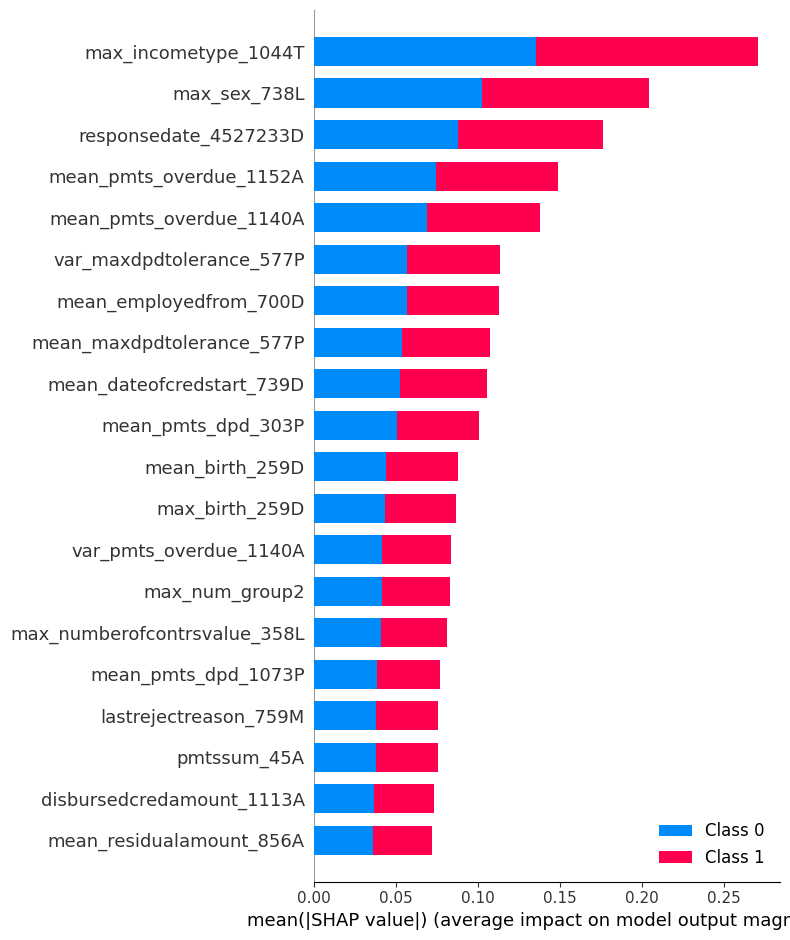

In [21]:
import shap
import matplotlib.pyplot as plt

# Ensure the latest LightGBM model is used
model_lgb = fitted_models_lgb[-1]

# Sample a small batch from validation set
X_sample = X_valid.sample(n=2000, random_state=42).copy()

# Create SHAP TreeExplainer for LGBM
explainer = shap.TreeExplainer(model_lgb)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# Summary plot — no .values or feature_names needed!
shap.summary_plot(shap_values, X_sample)


SHAP shape: (2000, 469)


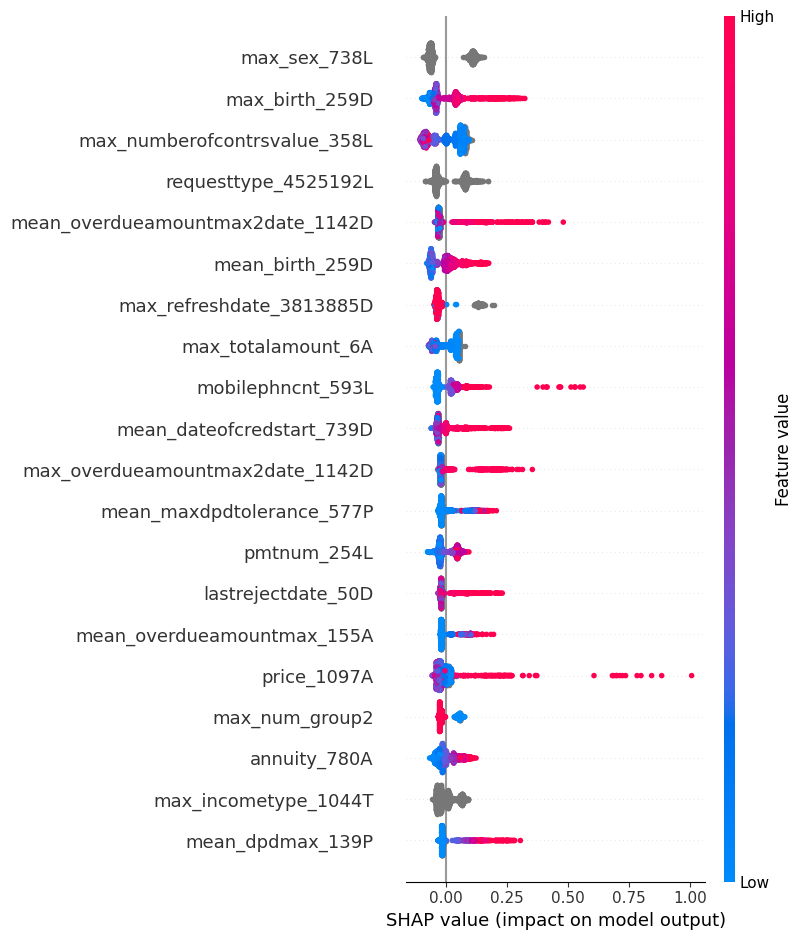

In [23]:
import shap
import matplotlib.pyplot as plt

# Use the latest trained CatBoost model
model_cat = fitted_models_cat[-1]

# Sample data for SHAP
X_sample_cat = X_valid.sample(n=2000, random_state=42).copy()

# Use CatBoost's native prediction_type='RawFormulaVal' (log-odds)
explainer_cat = shap.TreeExplainer(model_cat)

# SHAP values as 2D array (n_samples x n_features)
shap_values_cat = explainer_cat.shap_values(X_sample_cat)

# Confirm shape before plotting
print("SHAP shape:", np.array(shap_values_cat).shape)

# Plot summary (no class slicing needed)
shap.summary_plot(shap_values_cat, X_sample_cat)


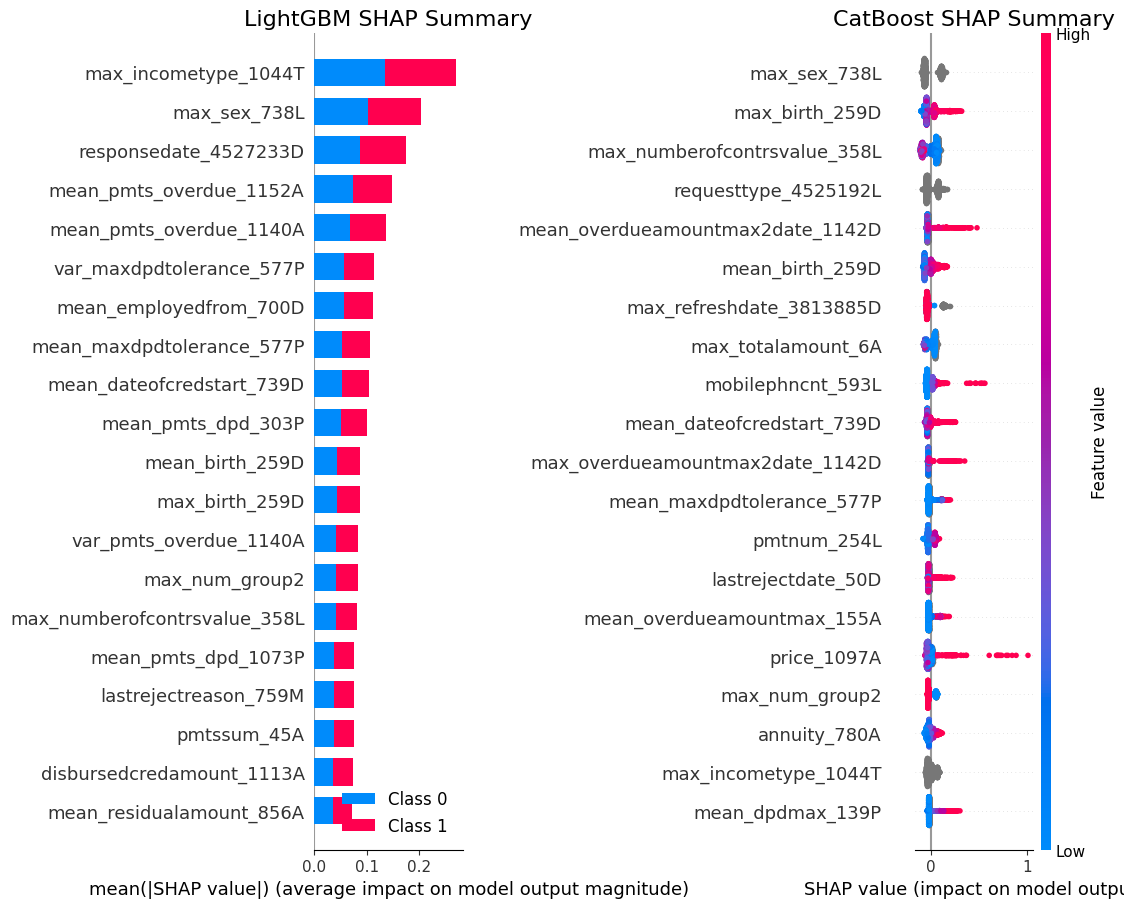

In [34]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Sample validation data
X_sample = X_valid.sample(n=2000, random_state=42).copy()

# LightGBM SHAP
model_lgb = fitted_models_lgb[-1]
explainer_lgb = shap.TreeExplainer(model_lgb)
shap_values_lgb = explainer_lgb.shap_values(X_sample)

# CatBoost SHAP
model_cat = fitted_models_cat[-1]
explainer_cat = shap.TreeExplainer(model_cat)
shap_values_cat = explainer_cat.shap_values(X_sample)

# Set up side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(24, 10))  # wider and taller

# LightGBM plot
plt.sca(axes[0])
shap.summary_plot(shap_values_lgb, X_sample, show=False, plot_size=(12, 10))
plt.title("LightGBM SHAP Summary", fontsize=16)

# CatBoost plot
plt.sca(axes[1])
shap.summary_plot(shap_values_cat, X_sample, show=False, plot_size=(12, 10))
plt.title("CatBoost SHAP Summary", fontsize=16)

# Final layout
plt.tight_layout(pad=4.0)
plt.savefig("shap_lightgbm_vs_catboost.png", dpi=300, bbox_inches="tight")
plt.show()


In [35]:
from IPython.display import FileLink

# Generate clickable download links for SHAP plots
FileLink(r'shap_outputs/shap_lgb_summary.png')


/kaggle/working/shap_outputs/shap_lgb_summary.png

In [37]:
from IPython.display import FileLink
FileLink(r'shap_outputs/shap_catboost_summary.png')


/kaggle/working/shap_outputs/shap_catboost_summary.png

In [27]:
import numpy as np
import pandas as pd

# Use SHAP values for Class 1 (target = 1)
shap_array_lgb = shap_values_lgb[1] if isinstance(shap_values_lgb, list) else shap_values_lgb
shap_array_cat = shap_values_cat  # Already 2D for CatBoost

# Top LightGBM Features
mean_shap_lgb = np.abs(shap_array_lgb).mean(axis=0)
top_lgb = pd.Series(mean_shap_lgb, index=X_sample.columns).sort_values(ascending=False).head(20)
print("🔹 Top LightGBM Features:\n", top_lgb)

# Top CatBoost Features
mean_shap_cat = np.abs(shap_array_cat).mean(axis=0)
top_cat = pd.Series(mean_shap_cat, index=X_sample.columns).sort_values(ascending=False).head(20)
print("\n🔸 Top CatBoost Features:\n", top_cat)


🔹 Top LightGBM Features:
 max_incometype_1044T            0.135303
max_sex_738L                    0.102115
responsedate_4527233D           0.087931
mean_pmts_overdue_1152A         0.074357
mean_pmts_overdue_1140A         0.068844
var_maxdpdtolerance_577P        0.056756
mean_employedfrom_700D          0.056435
mean_maxdpdtolerance_577P       0.053523
mean_dateofcredstart_739D       0.052541
mean_pmts_dpd_303P              0.050144
mean_birth_259D                 0.043780
max_birth_259D                  0.043273
var_pmts_overdue_1140A          0.041544
max_num_group2                  0.041462
max_numberofcontrsvalue_358L    0.040496
mean_pmts_dpd_1073P             0.038266
lastrejectreason_759M           0.037728
pmtssum_45A                     0.037670
disbursedcredamount_1113A       0.036571
mean_residualamount_856A        0.035932
dtype: float64

🔸 Top CatBoost Features:
 max_sex_738L                        0.082595
max_birth_259D                      0.063950
max_numberofcontrsvalu

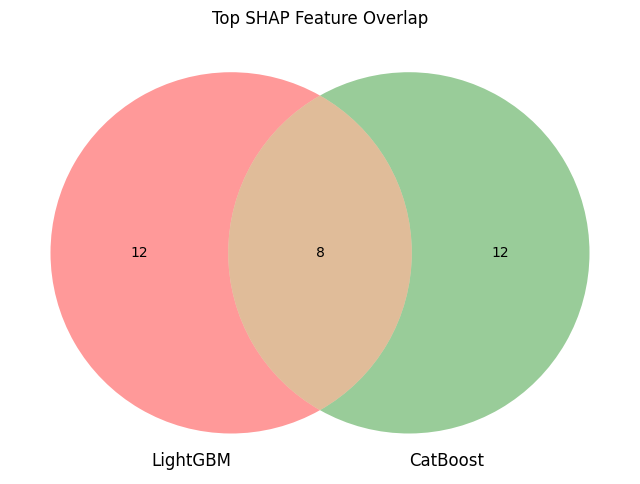

In [38]:
import numpy as np
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Compute top 20 SHAP features by mean absolute value
top_lgb = pd.Series(np.abs(shap_values_lgb[1]).mean(0), index=X_sample.columns).nlargest(20)
top_cat = pd.Series(np.abs(shap_values_cat).mean(0), index=X_sample.columns).nlargest(20)

# Create sets
set_lgb = set(top_lgb.index)
set_cat = set(top_cat.index)

# Plot and save Venn diagram
plt.figure(figsize=(8, 6))
venn2([set_lgb, set_cat], set_labels=("LightGBM", "CatBoost"))
plt.title("Top SHAP Feature Overlap")
plt.savefig("shap_outputs/shap_feature_overlap_venn.png", dpi=300, bbox_inches="tight")
plt.show()


In [39]:
from IPython.display import FileLink
FileLink(r'shap_outputs/shap_feature_overlap_venn.png')


/kaggle/working/shap_outputs/shap_feature_overlap_venn.png